In [ ]:

Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.
Метрика качества

F1-score (sklearn.metrics.f1_score)
Требования к решению

Целевая метрика: F1 > 0.5 Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)


In [89]:
#Загрузим библиотеки

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
import catboost as catb
import lightgbm as lgbm
import scipy.stats as stats
%matplotlib inline

#алгоритмы кластеризации

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

from pathlib import Path

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import statsmodels.api as sm
from statsmodels.formula.api import ols


In [ ]:
#использование специального модуля для игнорирования предупреждений

In [2]:
import warnings
warnings.simplefilter('ignore')

In [ ]:
# Загрузка данных

In [3]:
TRAIN_DATASET_PATH = 'C:/Users/vedma/Desktop/Kozhevnikova_project/course_project_train.csv'
TEST_DATASET_PATH = 'C:/Users/vedma/Desktop/Kozhevnikova_project/course_project_test.csv'

In [4]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [ ]:
#просмотр информации

In [5]:
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [ ]:
#проведем исследование и первичную обработку данных

In [6]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
#NEW_FEATURE_NAMES = ['']
NUMB_FEATURE_NAMES = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History',
                     'Maximum Open Credit','Number of Credit Problems','Months since last delinquent',
                     'Bankruptcies','Current Loan Amount','Current Credit Balance','Monthly Debt','Credit Score']
CAT_FEATURE_NAMES = ['Years in current job','Home Ownership','Purpose','Term']

In [7]:
y = df_train[[TARGET_NAME]]
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Credit Default  7500 non-null   int64
dtypes: int64(1)
memory usage: 58.7 KB


In [ ]:
#Рассмотрим распределение значений целевой переменной 

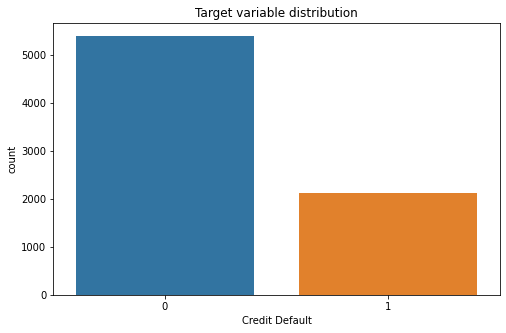

In [8]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

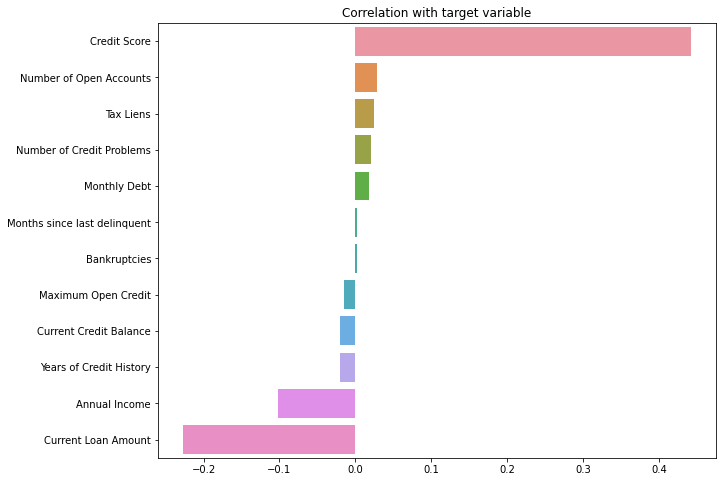

In [9]:
corr_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

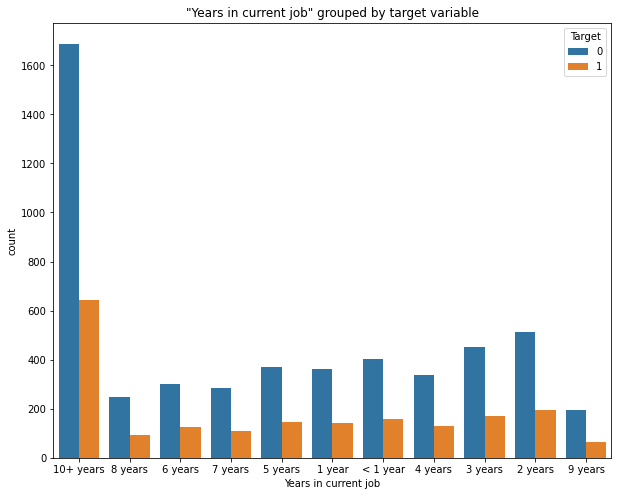

In [10]:
plt.figure(figsize=(10, 8))

sns.countplot(x="Years in current job", hue=TARGET_NAME, data=df_train)
plt.title('\"Years in current job\" grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [ ]:
#для дальнейшего анализа необходимо корректно обработать пропуски и возможные выбросы нашего датасета 

In [11]:
# пропуски
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [12]:
# Добавим новый бинарный признак - 1/0 (задолженость/отсутствие задолженности)
df_train['has_delay'] = 1
df_train.loc[(df_train['Months since last delinquent'] == 0), 'has_delay'] = 0

In [13]:
# Заменим пропуск NaN на 0 в 'Months since last delinquent'
df_train['Months since last delinquent'].fillna(0, inplace=True)

In [14]:
# Добавим новый бинарный признак о неизвестном доходе 1/0 (доход известен/доход не известен)
df_train['unknown_income'] = 0
df_train.loc[(df_train['Annual Income'].isnull()), 'unknown_income'] = 1

In [15]:
# В новую переменную annual_income_median запишим медианное значение дохода
annual_income_median = df_train['Annual Income'].median()

In [16]:
#Заполним пропуски дохода медианным значением
df_train['Annual Income'].fillna(annual_income_median, inplace=True)

In [17]:
#Посмотрим, что получилось
df_train.isnull().sum()
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,has_delay,unknown_income
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,1,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,1,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,1,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,1,0
5,Rent,1168386.0,7 years,0.0,12.0,14.6,366784.0,0.0,0.0,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1,1,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0,1,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1,1,0
8,Home Mortgage,1168386.0,5 years,0.0,17.0,15.7,0.0,1.0,0.0,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0,1,1
9,Home Mortgage,1168386.0,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1,1,1


In [18]:
NEW_FEATURE_NAMES = ['has_delay','unknown_income']

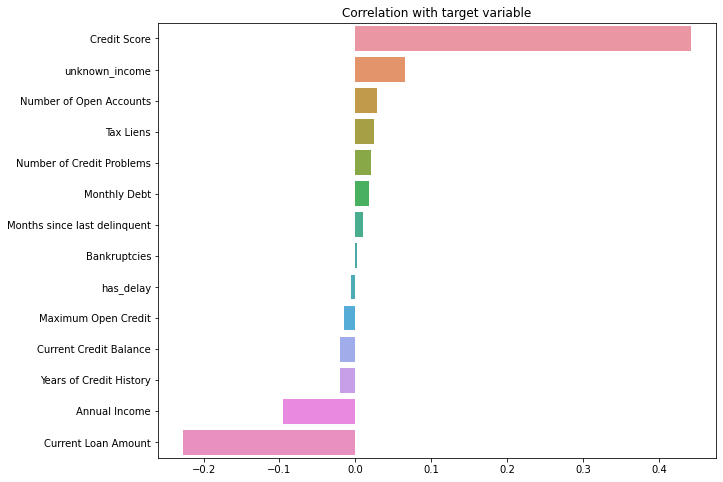

In [19]:
corr_with_target = df_train[BASE_FEATURE_NAMES + 
                            NEW_FEATURE_NAMES + 
                            [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [ ]:
#Анализ данных. Отбор признаков. Балансировка классов

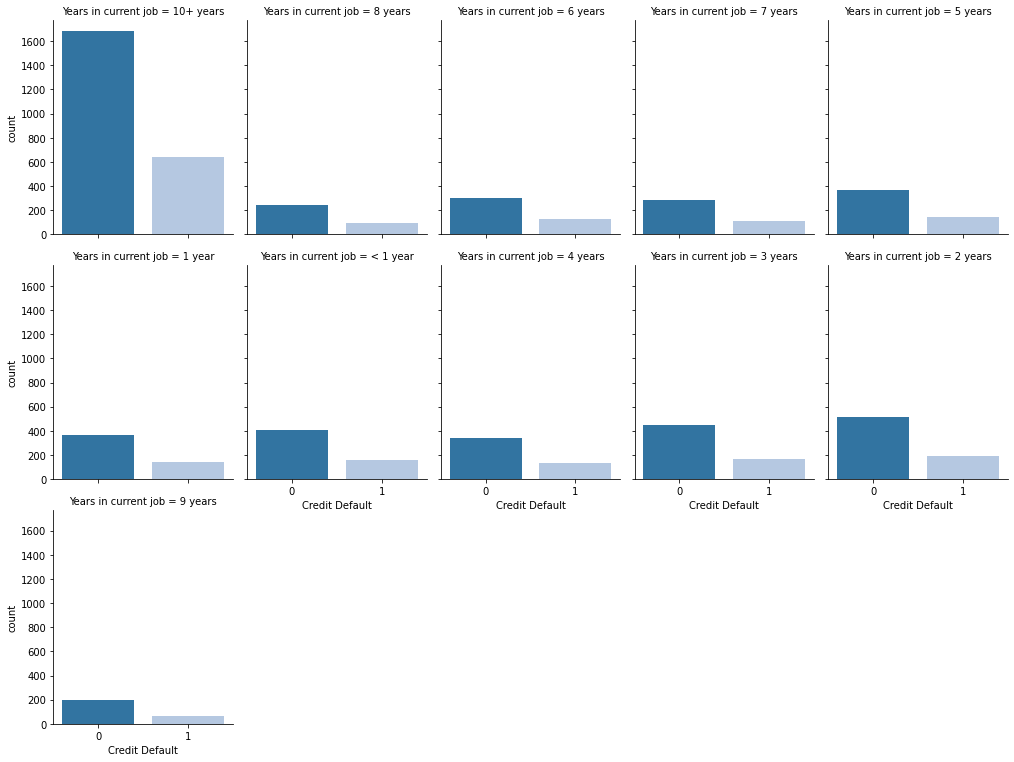

In [20]:
# Определим количества людей, в группах по стажу работы, не возвращающих кредит
g = sns.catplot("Credit Default", col="Years in current job", col_wrap=5,
                data=df_train,
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')

#fig.suptitle('sf')
plt.show()

In [21]:
df_train.isnull().sum()

Home Ownership                     0
Annual Income                      0
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
has_delay                          0
unknown_income                     0
dtype: int64

In [22]:
# Добавим новую переменную unknown_credit_score по неизвестному Credit Score с присвоением 0 всем наблюдениям 
df_train['unknown_credit_score'] = 0

NEW_FEATURE_NAMES = ['has_delay','unknown_income','unknown_credit_score']

In [23]:
# В переменную credit_score_median запишим медианное значение рейтинга
credit_score_median = df_train['Credit Score'].median()

In [24]:
# Присвоим 1 в переменной unknown_credit_score по известному кредитному рейтингу 
df_train.loc[(df_train['Credit Score'].isnull()), 'unknown_credit_score'] = 1

In [25]:
# А пропуски рейтинга заполним медианным значением
df_train['Credit Score'].fillna(credit_score_median, inplace=True)

In [26]:
# Уникальные значения Years in current job
years_in_current_job = df_train['Years in current job'].unique()

var_experiance = years_in_current_job[1:]

In [27]:
# NaN заменим на случайное значение
df_train['Years in current job'].fillna(random.choice(var_experiance), inplace=True)

In [28]:
df_train.isnull().sum()

Home Ownership                   0
Annual Income                    0
Years in current job             0
Tax Liens                        0
Number of Open Accounts          0
Years of Credit History          0
Maximum Open Credit              0
Number of Credit Problems        0
Months since last delinquent     0
Bankruptcies                    14
Purpose                          0
Term                             0
Current Loan Amount              0
Current Credit Balance           0
Monthly Debt                     0
Credit Score                     0
Credit Default                   0
has_delay                        0
unknown_income                   0
unknown_credit_score             0
dtype: int64

In [29]:
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,has_delay,unknown_income,unknown_credit_score
0,Own Home,482087.0,3 years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0,1,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0,1,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,1,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,1,0,0
5,Rent,1168386.0,7 years,0.0,12.0,14.6,366784.0,0.0,0.0,0.0,other,Long Term,337304.0,165680.0,18692.0,731.0,1,1,1,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0,1,0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1,1,0,0
8,Home Mortgage,1168386.0,5 years,0.0,17.0,15.7,0.0,1.0,0.0,1.0,home improvements,Short Term,129734.0,19.0,17.0,731.0,0,1,1,1
9,Home Mortgage,1168386.0,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,731.0,1,1,1,1


In [30]:
median_current_loan_amount = df_train['Current Loan Amount'].median()
df_train.loc[(df_train['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = median_current_loan_amount

In [31]:
df_train['Bankruptcies'].fillna(0 , inplace=True)

In [32]:
df_train.Bankruptcies.value_counts()

0.0    6674
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [33]:
df_train.isnull().sum()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
has_delay                       0
unknown_income                  0
unknown_credit_score            0
dtype: int64

In [43]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
3 years       991
2 years       705
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [44]:
df_train['term_binary'] = df_train['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)
NEW_FEATURE_NAMES = ['has_delay','unknown_income','unknown_credit_score','term_binary']

In [45]:
df_train.select_dtypes(include='object').columns[1:]

Index(['Years in current job', 'Purpose', 'Term'], dtype='object')

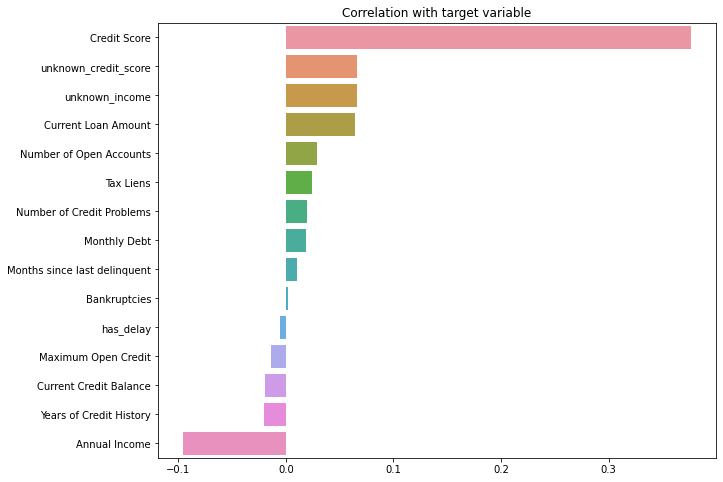

In [34]:
corr_with_target = df_train[BASE_FEATURE_NAMES + 
                            NEW_FEATURE_NAMES + 
                            [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [35]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [36]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [37]:
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,has_delay,unknown_income,unknown_credit_score
0,Own Home,482087.0,3 years,0.0,11.0,26.3,685960.0,1.0,0.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0,1,0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,1,0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0,1,0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,0.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,1,0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,1,0,0
5,Rent,1168386.0,7 years,0.0,12.0,14.6,366784.0,0.0,0.0,0.0,other,Long Term,337304.0,165680.0,18692.0,731.0,1,1,1,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,309573.0,51623.0,2317.0,745.0,0,1,0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1,1,0,0
8,Home Mortgage,1168386.0,5 years,0.0,17.0,15.7,0.0,1.0,0.0,1.0,home improvements,Short Term,129734.0,19.0,17.0,731.0,0,1,1,1
9,Home Mortgage,1168386.0,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,731.0,1,1,1,1


In [47]:
#нормализация
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUMB_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMB_FEATURE_NAMES])

df_train = df_norm.copy()

In [54]:
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.Categorical(df_train[colname])
    
df_train[CAT_FEATURE_NAMES].dtypes

Years in current job    category
Home Ownership          category
Purpose                 category
Term                    category
dtype: object

In [63]:
SELECTED_FEATURE_NAMES = NUMB_FEATURE_NAMES + NEW_FEATURE_NAMES

X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=11)

In [64]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3768
1    2964
Name: Credit Default, dtype: int64

In [65]:
#Логистическая регрессия

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      3768
           1       0.81      0.28      0.42      1482

    accuracy                           0.78      5250
   macro avg       0.79      0.63      0.64      5250
weighted avg       0.78      0.78      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      1619
           1       0.81      0.25      0.38       631

    accuracy                           0.77      2250
   macro avg       0.79      0.61      0.62      2250
weighted avg       0.78      0.77      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1582   37
1                474  157


In [66]:
#модель ближайших соседей

model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      3768
           1       0.78      0.47      0.58      1482

    accuracy                           0.81      5250
   macro avg       0.80      0.71      0.73      5250
weighted avg       0.81      0.81      0.80      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.90      0.83      1619
           1       0.55      0.30      0.39       631

    accuracy                           0.74      2250
   macro avg       0.66      0.60      0.61      2250
weighted avg       0.71      0.74      0.71      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1464  155
1                440  191


In [ ]:
#модель CatBoost  

model_catb = catb.CatBoostClassifier(silent=True, random_state=11)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
# Пересмотрев модели, я сделала вывод:

#CatBoost обладает гибкостью, позволяя задавать индексы категориальных столбцов, чтобы его можно было кодировать как кодирование в одно касание с использованием one_hot_max_size (обязательно нужно настроить для увеличения точности).
#LightGBM также может обрабатывать категориальные функции, вводя имена функций. Он не конвертируется в одноразовое кодирование и намного быстрее, чем одноразовое кодирование. LGBM использует специальный алгоритм, чтобы найти значение разделения категориальных признаков.
#XGBoost не может обрабатывать категориальные функции сам по себе, он принимает только числовые значения, подобные случайному лесу. Поэтому перед подачей категориальных данных в XGBoost необходимо выполнить различные кодировки, такие как кодирование меток, среднее кодирование или однократное кодирование.

#Таким образом, я остановила свой выбор на CatBoost

In [68]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=11)

In [ ]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [ ]:
cv=KFold(n_splits=3, random_state=11, shuffle=True)

In [ ]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

In [ ]:
rs.best_params_

In [ ]:
rs.best_score_

In [ ]:
#Борьба с переобучением

%%time

final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3,
                                      silent=True, random_state=11)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [69]:
#Подготовим тестовый датасет

#Добавим признак has_delay, всем наблюдениям присвоим 1
df_test['has_delay'] = 1

In [70]:
# Заменяним NaN на 0 в 'Months since last delinquent'
df_test['Months since last delinquent'].fillna(0, inplace=True)

In [71]:
# По отсутствующей задолженности присвоим 0 в has_delay
df_test.loc[(df_test['Months since last delinquent'] == 0), 'has_delay'] = 0

In [72]:
# Добавляем признак unknown_income, всем наблюдениям присвоим 0
df_test['unknown_income'] = 0

In [73]:
# В annual_income_median запишим медианное значение дохода
annual_income_median = df_test['Annual Income'].median()

In [74]:
# В unknown_income по неизвестному доходу присвоим 1 
df_test.loc[(df_test['Annual Income'].isnull()), 'unknown_income'] = 1

In [75]:
# Пропуски дохода заполним медианными значениями
df_test['Annual Income'].fillna(annual_income_median, inplace=True)

In [76]:
# Добавим признак unknown_credit_score, всем наблюдениям присвоим 0
df_test['unknown_credit_score'] = 0
NEW_FEATURE_NAMES = ['has_delay','unknown_income','unknown_credit_score']

In [77]:
# В credit_score_median запишем медианное значение рейтинга
credit_score_median = df_test['Credit Score'].median()

In [78]:
# В unknown_credit_score по неизвестному рейтингу присваиваем 1 
df_test.loc[(df_test['Credit Score'].isnull()), 'unknown_credit_score'] = 1

In [79]:
# Пропуски рейтинга заменяем медианными значениями
df_test['Credit Score'].fillna(credit_score_median, inplace=True)

In [80]:
# Уникальные значения поля Years in current job
unique_years_in_current_job = df_test['Years in current job'].unique()

var_experiance = unique_years_in_current_job[1:]

In [81]:
# NaN заменим рандомными значениями трудового стажа
df_test['Years in current job'].fillna(random.choice(var_experiance), inplace=True)

In [82]:
# 99999999.0 в Current Loan Amount заменяются на медианные
median_current_loan_amount = df_test['Current Loan Amount'].median()
df_test.loc[(df_test['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'] = median_current_loan_amount

df_test['term_binary'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [83]:
df_for_model = df_test[SELECTED_FEATURE_NAMES]
df_for_model.head(10)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,has_delay,unknown_income,unknown_credit_score,term_binary
0,1178475.0,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,162470.0,105906.0,6813.0,731.0,1,1,1,1
1,231838.0,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,78298.0,46037.0,2318.0,699.0,1,0,0,1
2,1152540.0,0.0,10.0,13.7,204600.0,0.0,0.0,0.0,200178.0,146490.0,18729.0,7260.0,0,0,0,1
3,1220313.0,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,217382.0,213199.0,27559.0,739.0,1,0,0,1
4,2340952.0,0.0,11.0,23.6,1207272.0,0.0,0.0,0.0,777634.0,425391.0,42605.0,706.0,0,0,0,0
5,922583.0,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,94028.0,135508.0,11148.0,679.0,1,0,0,1
6,1233309.0,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,454388.0,292904.0,8181.0,685.0,1,0,0,1
7,1215867.0,0.0,13.0,12.2,195888.0,0.0,19.0,0.0,407726.0,120099.0,7599.0,701.0,1,0,0,1
8,1178475.0,0.0,8.0,9.1,370524.0,0.0,0.0,0.0,131956.0,237747.0,10112.0,731.0,0,1,1,1
9,2140445.0,1.0,15.0,16.7,867680.0,1.0,9.0,0.0,391336.0,294500.0,18372.0,745.0,1,0,0,1


In [87]:
y_pred_output = final_model.predict(df_for_model)

In [91]:
y_pred_output.shape

In [93]:
result=pd.DataFrame({'Id':np.arange(2500), 'Credit Default': y_pred_output})

In [ ]:
RESULT_PATH='./Kozhevnikova_predictions.csv'
result.to_csv(RESULT_PATH, index=False)

In [ ]:
SAMPLE ='./Kozhevnikova_predictions.csv'
df_sample = pd.read_csv(SAMPLE)
predictions = pd.DataFrame(index = df_sample['Id'])

predictions[TARGET_NAME] = y_pred_output
predictions